# 2. Data analysis and processing

Goal: Data recognition and data preparation for analysis and model

## 2.1. Initial data analysis

pip install nltk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import collections as cl

# displaying charts in Jupyter Notebook
%matplotlib inline 


pd.options.display.float_format = "{:,.0f}".format # precision - zero decimal digits
np.random.seed(42)
np.set_printoptions(precision=6, suppress=True, edgeitems=10, linewidth=1000, formatter=dict(float=lambda x:f'{x:.2f}'))

In [2]:
#nltk.download() # Download/Refresh in window

In [3]:
DF_Statements = pd.read_json('./Data/Statements.json')
DF_Statements.set_index('id', inplace=True) # index setting
DF_Statements.sample(5)

,speaker,targets,statement,assessment,publication_date
id,,,,,
15910,Bloggers,[],<p>Says Brett &quot;Kavanaugh accuser Christin...,pants-fire,2018-09-25T16:29:00-04:00
18353,Facebook posts,[],Images show COVID-19 victims being buried in m...,mostly-true,2020-04-15T11:41:01-04:00
8432,Steve Spinnett,[],<p>Says Damascus&rsquo; disincorporation would...,false,2013-10-18T15:58:59-04:00
14358,Donald Trump,[],<p>&quot;The person in charge of the Hillary i...,barely-true,2017-07-25T12:15:18-04:00
12533,Barack Obama,[],<p>&quot;We&#39;ve seen more manufacturing job...,half-true,2016-06-16T14:19:41-04:00


In [4]:
# information about downloaded data
DF_Statements.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17614 entries, 18460 to 31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   speaker           17614 non-null  object
 1   targets           17614 non-null  object
 2   statement         17614 non-null  object
 3   assessment        17614 non-null  object
 4   publication_date  17614 non-null  object
dtypes: object(5)
memory usage: 8.0 MB


### 2.1.1 Assessment

**Truth-O-Meter ratings**

PolitiFact focus on looking at specific statements made by politicians and rating them for accuracy. 
The goal of the Truth-O-Meter is to reflect the relative accuracy of a statement. The meter has six ratings, in decreasing level of truthfulness:
1. TRUE – The statement is accurate and there’s nothing significant missing.
2. MOSTLY TRUE – The statement is accurate but needs clarification or additional information.
3. HALF TRUE – The statement is partially accurate but leaves out important details or takes things out of context.
4. MOSTLY FALSE – The statement contains an element of truth but ignores critical facts that would give a different impression.
5. FALSE – The statement is not accurate.
6. PANTS ON FIRE – The statement is not accurate and makes a ridiculous claim.

<img src="./Grahpics/truth_o_meter.png" width="600">

**Flip-O-Meter ratings**

The Flip-O-Meter rates an official's consistency on an issue. The rating is not making a value judgment about a politician who changes positions on an issue.The Flip-O-Meter has three ratings:

1. NO FLIP – No significant change in position.
2. HALF FLIP – A partial change in position.
3. FULL FLOP – A complete change in position.

<img src="./Grahpics/no-flip.JPG" width="400">
<img src="./Grahpics/18158_half-flip.JPG" width="400">
<img src="./Grahpics/full_flop.JPG" width="400">

https://www.politifact.com/article/2018/feb/12/principles-truth-o-meter-politifacts-methodology-i/

**Values in the column "assessment"**

In [5]:
DF_Statements["assessment"].nunique()

9

In [6]:
DF_Statements["assessment"].value_counts()

false          3656
half-true      3273
mostly-true    3099
barely-true    2901
true           2404
pants-fire     2022
full-flop       161
half-flip        71
no-flip          27
Name: assessment, dtype: int64

In [7]:
#assessments
DF_Statements.assessment.unique()

array(['false', 'pants-fire', 'mostly-true', 'half-true', 'barely-true', 'true', 'full-flop', 'half-flip', 'no-flip'], dtype=object)

Truth-O-Meter
1. True -> 'true' 
2. Mostly True -> 'mostly-true'
3. Half True -> 'half-true'
4. Mostly False -> 'barely-true'
5. False -> 'false'
6. Pants on Fire -> 'pants-fire'

Flip-O-Meter
1. No Flip -> 'no-flip'
2. Half Flip -> 'half-flip'
3. Full Flop -> 'full-flop'

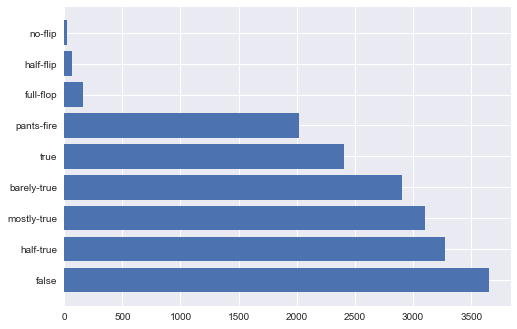

In [8]:
plt.style.use('seaborn',)
S_rate_conts = DF_Statements['assessment'].value_counts()
_ = plt.barh(y=S_rate_conts.index, width=S_rate_conts.values)

In [9]:
# deletion of Flip-O-Meter rows

v_noFlip = DF_Statements['assessment'] == 'no-flip'
print(len(DF_Statements[v_noFlip]),"rows with 'no-filp' to be deleted")
DF_Statements.drop(DF_Statements[v_noFlip].index, inplace=True)
      
v_halfFlip = DF_Statements['assessment'] == 'half-flip'
print(len(DF_Statements[v_halfFlip]),"rows with 'half-flip' to be deleted")
DF_Statements.drop(DF_Statements[v_halfFlip].index, inplace=True)
      
v_fullFlop = DF_Statements['assessment'] == 'full-flop'
print(len(DF_Statements[v_fullFlop]),"rows with 'full-flop' to be deleted")
DF_Statements.drop(DF_Statements[v_fullFlop].index, inplace=True)

27 rows with 'no-filp' to be deleted
71 rows with 'half-flip' to be deleted
161 rows with 'full-flop' to be deleted


Verifying deletion of rows

In [10]:
len(DF_Statements)

17355

In [11]:
#assessments
DF_Statements.assessment.unique()

array(['false', 'pants-fire', 'mostly-true', 'half-true', 'barely-true', 'true'], dtype=object)

### 2.1.2 Speaker

author of the statement

In [12]:
v_speaker_conts = DF_Statements['speaker'].value_counts()
v_speaker_conts.head(10)

Donald Trump       788
Barack Obama       602
Facebook posts     581
Bloggers           557
Viral image        356
Hillary Clinton    299
Mitt Romney        206
Scott Walker       201
John McCain        184
Chain email        181
Name: speaker, dtype: int64

In [13]:
# pivot table with the numbers of assessments for each author (speaker)
DF_SpeakerAssessmentCount = DF_Statements.pivot_table(index='speaker',
                                                      columns='assessment',
                                                      values='statement',
                                                      aggfunc='count')

# converting empty values to zeros
DF_SpeakerAssessmentCount.fillna(value=0, inplace=True)

# new column with the sum of the number of assessments for each speaker
DF_SpeakerAssessmentCount.insert(loc=6, 
                                 column='all_assessment', 
                                 value=DF_SpeakerAssessmentCount['true'] + 
                                 DF_SpeakerAssessmentCount['mostly-true']+
                                 DF_SpeakerAssessmentCount['half-true']+
                                 DF_SpeakerAssessmentCount['barely-true']+
                                 DF_SpeakerAssessmentCount['false']+
                                 DF_SpeakerAssessmentCount['pants-fire'])

# sorting by the largest number of 'pants of fire'
DF_SpeakerAssessmentCount.sort_values(by="all_assessment", ascending=False, inplace = True)

# reordering columns
DF_SpeakerAssessmentCount = DF_SpeakerAssessmentCount[['all_assessment', 'pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']]
DF_SpeakerAssessmentCount.head(10)

assessment,all_assessment,pants-fire,false,barely-true,half-true,mostly-true,true
speaker,,,,,,,
Donald Trump,788,121,274,167,111,81,34
Barack Obama,602,9,71,71,162,165,124
Facebook posts,581,175,263,65,40,25,13
Bloggers,557,343,130,36,22,18,8
Viral image,356,141,171,24,12,5,3
Hillary Clinton,299,9,31,42,69,76,72
Mitt Romney,206,19,32,34,58,33,30
Scott Walker,201,11,43,39,38,44,26
John McCain,184,8,39,32,31,37,37


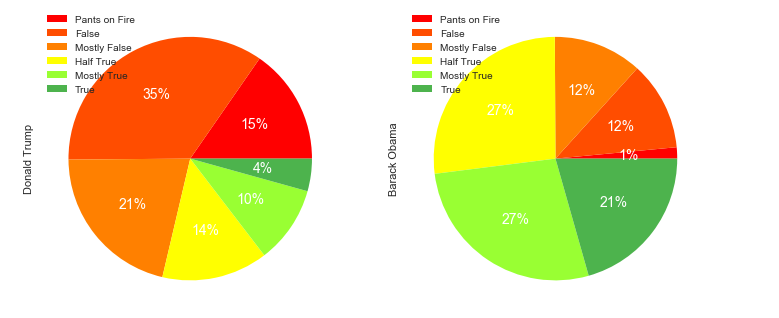

In [14]:
#Two speakers with the most statements
plt.style.use('seaborn')
_ = DF_SpeakerAssessmentCount.iloc[0:2,1:].T.plot(
    kind='pie',
    subplots=True,figsize=(12,12),
    labels=['Pants on Fire','False','Mostly False','Half True','Mostly True','True'],
    legend=True,
    autopct='%.0f%%',
    textprops=dict(color='w'),
    fontsize=14,
    colors=[(1,0,0),(1,0.3,0),(1,0.5,0),(1,1,0),(0.6,1,0.2),(0.3,0.7,0.3)])

In [15]:
# percentage of false and true statements
DF_SpeakerAssessmentCount["pants-fire_percent"] = DF_SpeakerAssessmentCount["pants-fire"]*100/DF_SpeakerAssessmentCount["all_assessment"]
DF_SpeakerAssessmentCount["true_percent"] = DF_SpeakerAssessmentCount["true"]*100/DF_SpeakerAssessmentCount["all_assessment"]
DF_SpeakerAssessmentCount.sort_values(by="pants-fire_percent", ascending=False, inplace = True)

In [16]:
# the 15 largest liars from those speakers who have 30 or more assessments
DF_SpeakerAssessmentCount.query('all_assessment >= 30').sort_values(by="pants-fire_percent", ascending=False).head(15)

assessment,all_assessment,pants-fire,false,barely-true,half-true,mostly-true,true,pants-fire_percent,true_percent
speaker,,,,,,,,,
Bloggers,557,343,130,36,22,18,8,62,1
Chain email,181,107,44,11,8,5,6,59,3
Viral image,356,141,171,24,12,5,3,40,1
Facebook posts,581,175,263,65,40,25,13,30,2
Michele Bachmann,61,16,22,8,6,4,5,26,8
Democratic Congressional Campaign Committee,38,9,8,13,7,1,0,24,0
Rush Limbaugh,43,10,16,10,5,2,0,23,0
Dan Patrick,35,7,5,5,4,7,7,20,20
Glenn Beck,31,6,7,5,7,2,4,19,13


In [17]:
# The 15 most truthful speakers from among those who have at least 30 ratings
DF_SpeakerAssessmentCount.query('all_assessment >= 30').sort_values(by="true_percent", ascending=False).head(15)

assessment,all_assessment,pants-fire,false,barely-true,half-true,mostly-true,true,pants-fire_percent,true_percent
speaker,,,,,,,,,
Andrew Cuomo,34,0,3,5,8,3,15,0,44
Sherrod Brown,38,1,4,4,6,9,14,3,37
Rob Portman,48,1,5,3,11,11,17,2,35
George Will,33,1,7,7,3,5,10,3,30
John Cornyn,32,1,4,6,8,4,9,3,28
Nathan Deal,49,0,5,9,11,11,13,0,27
Cory Booker,31,0,6,2,4,11,8,0,26
John Kasich,64,3,8,9,10,18,16,5,25
John Boehner,69,2,22,13,11,4,17,3,25


In [18]:
DF_SpeakerAssessmentCount.head()

assessment,all_assessment,pants-fire,false,barely-true,half-true,mostly-true,true,pants-fire_percent,true_percent
speaker,,,,,,,,,
Judy Manning,1,1,0,0,0,0,0,100,0
USA Daily Portal,1,1,0,0,0,0,0,100,0
Amardeep Kaleka,1,1,0,0,0,0,0,100,0
Top Stories USA,1,1,0,0,0,0,0,100,0
Town hall audience member,1,1,0,0,0,0,0,100,0


In [19]:
DF_SpeakerAssessmentCount.query('all_assessment >= 30').sort_values(by="pants-fire_percent", ascending=False).iloc[0:2,1:7].T

speaker,Bloggers,Chain email
assessment,,
pants-fire,343,107
false,130,44
barely-true,36,11
half-true,22,8
mostly-true,18,5
true,8,6


### 2.1.3 Target of statement

In [20]:
# targets of statements
v_targets = DF_Statements['targets'] 
v_targets = v_targets[v_targets.apply(len)>0] # rows with targets
v_targets.head()

id
18451           [Joe Biden]
18437    [Gretchen Whitmer]
18420    [Gretchen Whitmer]
18414          [Bill Gates]
18404          [Bill Gates]
Name: targets, dtype: object

In [21]:
# tabular summary of the number of assessments for speaker-target pairs
DF_Statements_copy = DF_Statements.copy()
DF_Statements_copy.reset_index(inplace=True)
DF_Statements_copy.drop(axis=1, columns=['statement','publication_date'], inplace=True)
DF_Statements_copy.head()

,id,speaker,targets,assessment
0,18460,Rudy Giuliani,[],false
1,18456,Facebook posts,[],pants-fire
2,18459,Facebook posts,[],false
3,18458,Viral image,[],false
4,18457,Tony Evers,[],mostly-true


In [22]:
# tabular summary of assessments of speakers' statements about targets

v_speakerTargetAssessment = {} # dictionary to create a Data Frame
v_id = []
v_speakers = []
v_targets = []
v_assessments = []

i=0
for i in range(len(DF_Statements)):
    if len(DF_Statements_copy['targets'].iloc[i]) > 0:
        for v_target in DF_Statements_copy.iloc[i][2]:
            v_id.append(DF_Statements_copy.iloc[i][0])
            v_speakers.append(DF_Statements_copy.iloc[i][1])
            v_targets.append(v_target)
            v_assessments.append(DF_Statements_copy.iloc[i][3])


v_speakerTargetAssessment['id'] = v_id
v_speakerTargetAssessment['speaker'] = v_speakers
v_speakerTargetAssessment['target'] = v_targets
v_speakerTargetAssessment['assessment'] = v_assessments

# Data Frame with speakers, targets and assessments
DF_SpeakerTargetAssessment = pd.DataFrame(data=v_speakerTargetAssessment)
DF_SpeakerTargetAssessment.head()

,id,speaker,target,assessment
0,18451,Facebook posts,Joe Biden,pants-fire
1,18437,Instagram posts,Gretchen Whitmer,barely-true
2,18420,Facebook posts,Gretchen Whitmer,false
3,18414,Facebook posts,Bill Gates,false
4,18404,Facebook posts,Bill Gates,false


In [23]:
# pivot table with the number of assessments
DF_SpeakerTargetAssessmentCount = DF_SpeakerTargetAssessment.pivot_table(index=['speaker','target'],
                                                                         columns='assessment',
                                                                         values='id',
                                                                         aggfunc='count')
# converting empty values to zeros
DF_SpeakerTargetAssessmentCount.fillna(value=0, inplace=True)

# new column with the sum of the number of assessments for each speaker
DF_SpeakerTargetAssessmentCount.insert(loc=6,
                                       column='all_assessment', 
                                       value=DF_SpeakerTargetAssessmentCount['true'] + 
                                       DF_SpeakerTargetAssessmentCount['mostly-true']+
                                       DF_SpeakerTargetAssessmentCount['half-true']+
                                       DF_SpeakerTargetAssessmentCount['barely-true']+
                                       DF_SpeakerTargetAssessmentCount['false']+
                                       DF_SpeakerTargetAssessmentCount['pants-fire'])

# sorting by the largest number of 'pants of fire'
DF_SpeakerTargetAssessmentCount.sort_values(by="all_assessment", ascending=False, inplace = True)

# reordering columns
DF_SpeakerTargetAssessmentCount = DF_SpeakerTargetAssessmentCount[['all_assessment', 'pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']]
DF_SpeakerTargetAssessmentCount.head(10)

,assessment,all_assessment,pants-fire,false,barely-true,half-true,mostly-true,true
speaker,target,,,,,,,
Mitt Romney,Barack Obama,74,11,14,17,21,6,5
Donald Trump,Hillary Clinton,68,10,22,17,11,8,0
Barack Obama,Mitt Romney,56,1,2,9,20,14,10
Hillary Clinton,Donald Trump,41,1,1,5,8,12,14
Viral image,Donald Trump,35,16,17,1,1,0,0
Chain email,Barack Obama,35,27,4,3,1,0,0
Donald Trump,Barack Obama,22,7,5,1,5,4,0
Charlie Crist,Rick Scott,22,0,3,3,6,8,2
Mary Burke,Scott Walker,19,3,1,4,7,3,1


In [24]:
DF_SpeakerTargetAssessmentCount.iloc[0]

assessment
all_assessment   74
pants-fire       11
false            14
barely-true      17
half-true        21
mostly-true       6
true              5
Name: (Mitt Romney, Barack Obama), dtype: float64

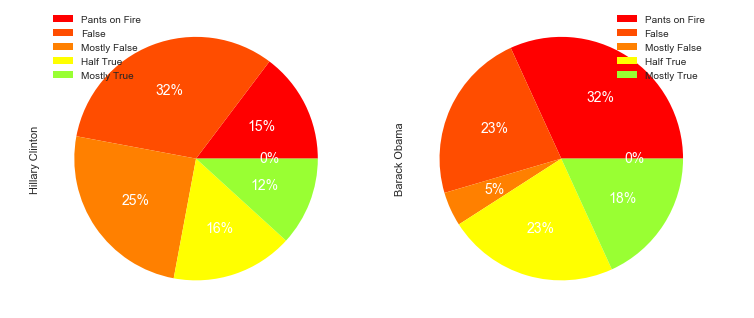

In [25]:
# Speaker - Donald Trump and the two most common targets
_ = DF_SpeakerTargetAssessmentCount.loc['Donald Trump'].iloc[0:2,1:].T.plot(
    kind='pie',
    subplots=True,
    figsize=(12,12),
    labels=['Pants on Fire','False','Mostly False','Half True','Mostly True','True'],
    legend=True,
    autopct='%.0f%%',
    textprops=dict(color='w'),
    fontsize=14,
    colors=[(1,0,0),(1,0.3,0),(1,0.5,0),(1,1,0),(0.6,1,0.2),(0.3,0.7,0.3)])

In [26]:
DF_DonaldTramp6TargetAssessment = DF_SpeakerTargetAssessmentCount.loc['Donald Trump'].sort_values(by="all_assessment", ascending=False).head(6)
DF_DonaldTramp6TargetAssessment

assessment,all_assessment,pants-fire,false,barely-true,half-true,mostly-true,true
target,,,,,,,
Hillary Clinton,68,10,22,17,11,8,0
Barack Obama,22,7,5,1,5,4,0
Ted Cruz,5,2,2,0,0,1,0
Joe Biden,5,0,2,3,0,0,0
Jeb Bush,4,0,1,2,0,1,0
Carly Fiorina,2,0,0,0,0,2,0


In [27]:
# percentage of false and true statements
DF_SpeakerTargetAssessmentCount["pants-fire_percent"] = DF_SpeakerTargetAssessmentCount["pants-fire"]*100/DF_SpeakerTargetAssessmentCount["all_assessment"]
DF_SpeakerTargetAssessmentCount["true_percent"] = DF_SpeakerTargetAssessmentCount["true"]*100/DF_SpeakerTargetAssessmentCount["all_assessment"]
DF_SpeakerTargetAssessmentCount.sort_values(by="pants-fire_percent", ascending=False, inplace = True)

In [28]:
# who lies most often about whom
DF_SpeakerTargetAssessmentCount.query('all_assessment >= 5').sort_values(by="pants-fire_percent", ascending=False).head(10)

assessment                            all_assessment  pants-fire  false  \
speaker     target                                                        
Viral image Ilhan Omar                             6           5      1   
            Beto O'Rourke                          5           4      1   
Chain email Barack Obama                          35          27      4   
Viral image Alexandria Ocasio-Cortez               8           6      2   
Bloggers    Barack Obama                          12           8      1   
Viral image Hillary Clinton                       14           9      4   
            Nancy Pelosi                           8           5      3   
Bloggers    Nancy Pelosi                          13           8      2   
            Hillary Clinton                        7           4      2   
Viral image Barack Obama                           8           4      3   

assessment                            barely-true  half-true  mostly-true  \
speaker     target                                                          
Viral image Ilhan Omar                          0          0            0   
            Beto O'Rourke                       0          0            0   
Chain email Barack Obama                        3          1            0   
Viral image Alexandria Ocasio-Cortez            0          0            0   
Bloggers    Barack Obama                        2          0            1   
Viral image Hillary Clinton                     0          1            0   
            Nancy Pelosi                        0          0            0   
Bloggers    Nancy Pelosi                        1          2            0   
            Hillary Clinton                     1          0            0   
Viral image Barack Obama                        0          0            0   

assessment                            true  pants-fire_percent  true_percent  
speaker     target                                                            
Viral image Ilhan Omar                   0                  83             0  
            Beto O'Rourke                0                  80             0  
Chain email Barack Obama                 0                  77             0  
Viral image Alexandria Ocasio-Cortez     0                  75             0  
Bloggers    Barack Obama                 0                  67             0  
Viral image Hillary Clinton              0                  64             0  
            Nancy Pelosi                 0                  62             0  
Bloggers    Nancy Pelosi                 0                  62             0  
            Hillary Clinton              0                  57             0  
Viral image Barack Obama                 1                  50            12

In [29]:
# who usually tells the truth about whom
DF_SpeakerTargetAssessmentCount.query('all_assessment >= 5').sort_values(by="true_percent", ascending=False).head(10)

,assessment,all_assessment,pants-fire,false,barely-true,half-true,mostly-true,true,pants-fire_percent,true_percent
speaker,target,,,,,,,,,
Kendrick Meek,Jeff Greene,6,0,0,1,0,1,4,0,67
Bill McCollum,Rick Scott,5,0,1,1,0,0,3,0,60
Edward Cox,Andrew Cuomo,5,0,0,0,1,2,2,0,40
Hillary Clinton,Donald Trump,41,1,1,5,8,12,14,2,34
Florida Democratic Party,Bill McCollum,6,2,0,0,1,1,2,33,33
David Dewhurst,Barack Obama,6,1,1,1,0,1,2,17,33
Marco Rubio,Charlie Crist,13,1,2,1,3,2,4,8,31
Alan Grayson,Daniel Webster,7,0,1,1,1,2,2,0,29
Republican National Committee,Barack Obama,8,0,1,0,3,2,2,0,25


### 2.1.4 Statement

In [30]:
# texts of ten sample statements before processing
pd.options.display.max_colwidth=300
for i in range(len(DF_Statements.statement)):
    print(DF_Statements.statement.iloc[i])
    if i > 10:
        break

"Why did the US (NIH) in 2017 give $3.7m to the Wuhan Lab in China? Such grants were prohibited in 2014. Did Pres. Obama grant an exception?"
Homeless people are immune to COVID-19
Says President Donald Trump is selling coronavirus-themed commemorative coins through the White House Gift Shop.
Walmart, Amazon, Kroger, Target and Costco “have not had any reported (coronavirus) cases in the news.”
Says Wisconsin measures have "prevented the death of at least 300 Wisconsinites, and perhaps as many as 1,400 lives."
The existence of a canine coronavirus vaccine casts doubt on statements that there isn’t one for humans.
Says President Barack Obama "signed the medical appliance tax bill that forced companies to outsource manufacturing of masks, gowns, gloves and ventilaors [sic] to China, Europe and Russia to avoid the tax.”
The CDC recommends that only people with COVID-19 symptoms should wear masks.
“Pelosi was in (Wuhan) China 6 days after the impeachment HOAX failed.”
Says a video shows Jo

In [31]:
# longest statement
print(DF_Statements.statement.max())
print(len(DF_Statements.statement.max()),'characters')

”If you line up all the countries that have done (Covid-19) testing on a per-capita basis, we’re at the bottom of the list.”
124 characters


## 2.2 Text processing in statements

### 2.2.1 Text cleaning and normalization

In [32]:
# items in overhangs <...> to remove from text
LIST_ToRemove = [] # list for items to remove in statement 
for v_statement in DF_Statements.statement:
    LIST_ToRemove.extend(re.findall("<.+?>",v_statement))
SET_ToRemove = set(LIST_ToRemove ) 
SET_ToRemove # elements in the statement to be deleted

{'<!--EndFragment-->',
 '<!--StartFragment-->',
 '<!--[endif]-->',
 '<!--[if !supportLineBreakNewLine]-->',
 '</a>',
 '</b>',
 '</blockquote>',
 '</div>',
 '</em>',
 '</font>',
 '</h1>',
 '</h2>',
 '</i>',
 '</p>',
 '</span>',
 '</strong>',
 '</table>',
 '</tbody>',
 '</td>',
 '</tr>',
 '</u>',
 '</wbr>',
 '<a href="http://chicago.suntimes.com/news/emanuel-accepts-rauner-apology-for-insult-to-teachers-principals/">',
 '<a href="http://savannahnow.com/bryan-county-now/2012-04-12/jack-kingston-rising-gas-prices-threaten-meager-signs-recovery">',
 '<a href="http://twitter.com/#%21/search?q=%235vtshow">',
 '<a href="http://w3.nexis.com/new/search/XMLCrossLinkSearch.do?bct=A&amp;risb=21_T17948015652&amp;returnToId=20_T17948015673&amp;csi=257765&amp;A=0.5966888718307183&amp;sourceCSI=162599&amp;indexTerm=%23PE0009TJP%23&amp;searchTerm=Obama%20&amp;indexType=P">',
 '<a href="http://walden.house.gov/index.cfm?sectionid=123&amp;sectiontree=3,123">',
 '<a href="http://www.asianam.org/affirmative

In [33]:
# items in overhangs {...} to remove from text
LIST_ToRemove = [] # list for items to remove in statement 
for v_statement in DF_Statements.statement:
    LIST_ToRemove.extend(re.findall("{.+?}",v_statement))
SET_ToRemove = set(LIST_ToRemove ) 
SET_ToRemove # elements in the statement to be deleted

set()

In [34]:
DF_Statements.insert(loc=4, column='cleaned_statement', value='') # new column

for i,v_statement in enumerate(DF_Statements.statement):

    # quotation marks and apostrophes
    v_statement = v_statement.replace(r'&quot;', ' ')   # removing quote -> "
    v_statement = v_statement.replace(r'‘', ' ')        # removing apostrophe -> ‘
    v_statement = v_statement.replace(r'’', '\'')       # change to apostrophe -> '
    v_statement = v_statement.replace(r'&#39;', '\'')   # change to apostrophe -> '  (e.g: people&#39;s property -> people's property)
    v_statement = v_statement.replace(r'&rsquo;', '\'') # change to apostrophe -> '  (e.g: Trump&rsquo;s hold -> Trump's)
    v_statement = v_statement.replace(r'&lsquo;', '\'') # change to apostrophe -> '
    v_statement = v_statement.replace('\r quot', ' ')
    v_statement = v_statement.replace('quot \r', ' ')
    v_statement = v_statement.replace('quot', ' ')
              
    v_statement = v_statement.replace('\n', ' ')        # removing end of line markers            
    v_statement = v_statement.replace('\t', ' ')        # removing tab markers
    v_statement = v_statement.replace('\r', ' ')        
    
    v_statement = v_statement.replace(r'&nbsp;', ' ')
    v_statement = v_statement.replace(r'&mdash;', ' ')
    v_statement = v_statement.replace(r'&hellip;', ' ')
    v_statement = v_statement.replace(r'&amp;', ' ')
    v_statement = v_statement.replace(r'\ufeff', ' ')    
    
    v_statement = re.sub('<.+?>', ' ', v_statement)                                   # removing html tags
    
    v_statement = re.sub(r'[!@#^&*_=+(){}<>?,.…;:~`"“”ʺ/]', '', v_statement)          # $ -> Dollars, % -> percent (change to class names)
    v_statement = v_statement.replace(r'[', '')
    v_statement = v_statement.replace(r']', '')
        
    v_statement = v_statement.replace('US', 'USA')
    
    v_statement = v_statement.lower()                                                 # change uppercase letters to lower case
    
    #word classes
    v_statement = re.sub(r' in [0-9]{4}',' in_YEAR', v_statement)                     # date normalization
    
    v_statement = re.sub(r'[$]([0-9]{1,}[,.]{0,1})+[bkmt]{0,1}( billion){0,1}( million){0,1}( trillion){0,1}','_DOLLARS', v_statement)  # normalization of money in Dollars
    v_statement = re.sub(r'([0-9]{1,}[,.-]{0,1})+ percent','_PERCENT', v_statement)   # normalization of percents
    v_statement = re.sub(r'([0-9]{1,}[,.]{0,1})+%','_PERCENT', v_statement)           # normalization of percents
    v_statement = re.sub(r'([0-9]{1,}[,.]{0,1})+§','_PARAGRAPHS', v_statement)        # normalization of paragraphs
    
    v_statement = re.sub(r' ([0-9]{1,}[,.]{0,1})+[bkmt]{0,1}',' _NUMBER', v_statement)# normalization of numbers (b - billion, k - kilo, m - million, t - trillion)
    
    v_statement = re.sub(r' \w ',' ', v_statement)                                    # removing single charakters 
    
    DF_Statements.cleaned_statement.iloc[i] = v_statement                             # insert cleaned statement into DataFrame

The numbers are not removed because their use in the statement may affect the assessment of truth

In [35]:
DF_Statements.head()

,speaker,targets,statement,assessment,cleaned_statement,publication_date
id,,,,,,
18460,Rudy Giuliani,[],"""Why did the US (NIH) in 2017 give $3.7m to the Wuhan Lab in China? Such grants were prohibited in 2014. Did Pres. Obama grant an exception?""",false,why did the usa nih in_YEAR give _DOLLARS to the wuhan lab in china such grants were prohibited in_YEAR did pres obama grant an exception,2020-05-01T17:34:36-04:00
18456,Facebook posts,[],Homeless people are immune to COVID-19,pants-fire,homeless people are immune to covid-19,2020-05-01T17:19:18-04:00
18459,Facebook posts,[],Says President Donald Trump is selling coronavirus-themed commemorative coins through the White House Gift Shop.,false,says president donald trump is selling coronavirus-themed commemorative coins through the white house gift shop,2020-05-01T17:18:14-04:00
18458,Viral image,[],"Walmart, Amazon, Kroger, Target and Costco “have not had any reported (coronavirus) cases in the news.”",false,walmart amazon kroger target and costco have not had any reported coronavirus cases in the news,2020-05-01T16:05:36-04:00
18457,Tony Evers,[],"Says Wisconsin measures have ""prevented the death of at least 300 Wisconsinites, and perhaps as many as 1,400 lives.""",mostly-true,says wisconsin measures have prevented the death of at least _NUMBER wisconsinites and perhaps as many as _NUMBER lives,2020-05-01T12:54:52-04:00


**Cleaned statement text**

In [36]:
DF_Statements.sample(5)

,speaker,targets,statement,assessment,cleaned_statement,publication_date
id,,,,,,
15695,Republican Party of Wisconsin,[Tony Evers],<p>Says Tony Evers &quot;didn&#39;t revoke the license of a teacher caught spreading pornography and commenting on the bodies of middle-school girls.&quot;</p>\r\n,half-true,says tony evers didn't revoke the license of teacher caught spreading pornography and commenting on the bodies of middle-school girls,2018-08-06T06:00:00-04:00
15123,Meddaily,[],<p>The flu shot is &quot;designed to spread cancer.&quot;</p>\r\n,pants-fire,the flu shot is designed to spread cancer,2018-03-09T09:38:55-05:00
4616,Burnt Orange Report,[Donna Campbell],<p>\r\n\tSays Texas Senate hopeful Donna Campbell doesn&rsquo;t live in the district she&rsquo;s hoping to win in 2012.</p>,barely-true,says texas senate hopeful donna campbell doesn't live in the district she's hoping to win in_YEAR,2011-10-17T06:00:00-04:00
7504,Nan Orrock,[],<p>\r\n\t&quot;More than 80 percent of Americans believe we need to have universal background checks.&quot;</p>\r\n,true,more than _PERCENT of americans believe we need to have universal background checks,2013-03-12T06:00:00-04:00
10500,Alcee Hastings,[],<p>A Texas law says &quot;that you can&rsquo;t shoot bears out of the second floor of a window.&quot;</p>\r\n,pants-fire,texas law says that you can't shoot bears out of the second floor of window,2015-02-12T10:57:27-05:00


### 2.2.2 Tokenization
separate text into words

In [37]:
tokenized_statements = [] # list of words used in statements
for v_statement in DF_Statements.cleaned_statement:
    tokenized_statements.append(nltk.word_tokenize(v_statement)) # breaking up the text into words

DF_Statements.insert(loc=5, column='tokenized_statement',value=tokenized_statements)
DF_Statements.head()

,speaker,targets,statement,assessment,cleaned_statement,tokenized_statement,publication_date
id,,,,,,,
18460,Rudy Giuliani,[],"""Why did the US (NIH) in 2017 give $3.7m to the Wuhan Lab in China? Such grants were prohibited in 2014. Did Pres. Obama grant an exception?""",false,why did the usa nih in_YEAR give _DOLLARS to the wuhan lab in china such grants were prohibited in_YEAR did pres obama grant an exception,"[why, did, the, usa, nih, in_YEAR, give, _DOLLARS, to, the, wuhan, lab, in, china, such, grants, were, prohibited, in_YEAR, did, pres, obama, grant, an, exception]",2020-05-01T17:34:36-04:00
18456,Facebook posts,[],Homeless people are immune to COVID-19,pants-fire,homeless people are immune to covid-19,"[homeless, people, are, immune, to, covid-19]",2020-05-01T17:19:18-04:00
18459,Facebook posts,[],Says President Donald Trump is selling coronavirus-themed commemorative coins through the White House Gift Shop.,false,says president donald trump is selling coronavirus-themed commemorative coins through the white house gift shop,"[says, president, donald, trump, is, selling, coronavirus-themed, commemorative, coins, through, the, white, house, gift, shop]",2020-05-01T17:18:14-04:00
18458,Viral image,[],"Walmart, Amazon, Kroger, Target and Costco “have not had any reported (coronavirus) cases in the news.”",false,walmart amazon kroger target and costco have not had any reported coronavirus cases in the news,"[walmart, amazon, kroger, target, and, costco, have, not, had, any, reported, coronavirus, cases, in, the, news]",2020-05-01T16:05:36-04:00
18457,Tony Evers,[],"Says Wisconsin measures have ""prevented the death of at least 300 Wisconsinites, and perhaps as many as 1,400 lives.""",mostly-true,says wisconsin measures have prevented the death of at least _NUMBER wisconsinites and perhaps as many as _NUMBER lives,"[says, wisconsin, measures, have, prevented, the, death, of, at, least, _NUMBER, wisconsinites, and, perhaps, as, many, as, _NUMBER, lives]",2020-05-01T12:54:52-04:00


### 2.2.3 Stopwords
Irrelevant words to be removed from statements

In [38]:
# list of stopwords
stopwords = nltk.corpus.stopwords.words('english')

# words that will not be removed from statements
neededStopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves',
                   'he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their',
                   'theirs','themselves'] # subject and object pronouns, possessive pronouns, reflexive pronouns

for v_word in neededStopwords:
    stopwords.remove(v_word)

# deleting stopwords
stopwords_statements = [[word for word in stt if (word not in stopwords)] for stt in tokenized_statements]


In [39]:
stpw = []
for lst in stopwords_statements:
    for word in lst:
        stpw.append(word)
for w in set(stpw):
    print(w)

swedish
outperformed
pakistani
investigating
little-known
gaetz
bioweapon
read
childcare
abortion
importing
likely
wipes
indian
ray
wide
twelve
neutral
bribery
second-lowest
minnick
motherhood
overstayed
taxcuts
milken
passed
built
rolls
spillover
leads
tweet
binge
sixth-highest
rebuilding
geo
state-mandated
insulin
generate
regulates
leaner
imposed
slogans
hivaids
odessa
youths
declining
revolutionary
redirect
neighbors
subsidy
introduction
ii
accident
lied
porter
‪lrmbernie‬
taught
firefighter
refinance
enjoys
reinstate
combustible
crow-era
walden
on-duty
carcasses
illnesses
_DOLLARS-trillion
diabetes
occur
sweater
robocalls
violating
hortons
rothschilds
meal
constrained
infestations
multimillionaires
misclassified
pacur
radicalized
trimmers
chance
eyeing
accelerating
get
kosher
sakonnet
renner
emirates
highest-performing
say
enhancement
dumped
no-no
morning
kahl
daniel
per-pupil
groom
sterilization
analysts
authoritarians
rosa
violets
orlando
ability
pack-a-day
rabid
screwed
neighbo

oxendine
enrollees
vehicles
acts
composing
specialty
scam
approaches
pressing
canned
readiness
taliban
interviewed
schrader
avert
franklin
viral
hp
internationally
meltdown
saunders
wish
infomercials
searched
cooperate
northeastern
credited
enthusiastically
constitute
sealed
stoned
delphi
corzine
skyline
feasible
invites
outflux
sachs
near
encouraging
pentagon
punishment
wawa
contribution
thibaut
acquaintance
'whistleblower
shockingly
disappointing
fly
ecot
stack
chanting
busting
tools
cancellation
smarter
respiratory
hype
renewal
place
border
cows
comprise
train
uber
property
irene
ebola
foxworthy
ricochets
lapel
metoo
drag
whitmer
holders
snatched
exorcism
facial
feingold
proceeds
use
filter
state-sanctioned
captured
committees
implementation
evading
ministries
lecture
metering
remained
cap
fought
glarus
human-jellyfish
energies
minus
harry
nationalist
arrivals
post-recession
commanders
confiscated
diseases
curbing
island-based
tip
hillarycare
conceive
answering
obsolete
arab
loading

ratification
done
choices
o'mara
active-duty
biggest
aspect
boomers
military
links
prescribers
automate
department
forwarded
wiretaps
christopher
wristbands
uaw
leadership
objectives
businessmen
opposition
preach
fairness
recognized
sherwin-williams
zakaria
'to
mph
ensure
distributed
goodell
three-quarters
entertained
mutations
impacted
iraqis
cramps
_NUMBER-34
cleansed
fall
bayles
son-in-law
decade
article
thus
ouzinkie
flynn
_NUMBER-'15
documents
egypt
records
adult-themed
influenza
affirmative
sens
percentage
collaboration
cinderella
endorse
handsomely
repaired
sticker
ammo
santorum
princess
obvious
matters
_NUMBER-1
caymans
oversaw
positive
re-elect
disdain
shipbuilders
buyers
running
gift
pell
tasted
cloonen
forge
'04
blatant
phenomenally
tarp
suffragettes
'if
sentence
seduce
center
lie
binoculars
mitigation
shot
ram
uploaded
murdoch
condemn
regardless
scif
judithanne
smart
curriculum
louie
insurgents
ration
reforms
technicality
falkland
butter-and-jelly
directions
intended
drowne

sellers
principle
share
noun
legendary
gainesville
loving
tortured
slavery
perimeter
sneaky
dying
android
exaggerated
offering
tammy
oxycodone-dispensing
icu
murkowski
aversion
stating
gender
production
doctored
selection
extends
starts
courtesies
scalia
alexandria
chadwell
begich
non-discrimination
tracker
alexa
forty
viagra
ethical
hillary
caravan
flatlined
tax-cut
caucasian
thirty-seven
stoves
news
assassinated
nonexistent
barred
strapped
contradictory
suppression
es
excursion
longstanding
astonishing
schneiderman
humayun
affirmed
sustained
concerts
limitations
tysons
fulton
specifically
drive-up
blake
biennially
coastal
ipads
cover-up
it
gesture
unpopular
never
aycha
detailed
prenatal
erupted
surveil
honeymoon
diebold
koalas
sonia
cigarette
predecessors
casinos
worse
reality
factcheckorg
supplies
probation
sunny
twitching
current
anti-fascists
pandemics
bradley
antidepressant
collections
espn
montpelier
ball
nc
advantage
fingerprinting
stamp
lone
'trumpcare
hybrids
tobacco
judged
p

lying
fuel
_NUMBER-mile
seminole
prohibited
climate
typical
mainland
jeopardizing
multiple
fivefold
'rigged
intends
_NUMBER
tribune
jake
kagen
fatal
emerged
in-country
mayor
re-elected
flip-flopped
rick
mcdonalds
job-killer
theorists
bashar
iced
pritzker
mars
explosives
shooters
unconscionable
giveways
polls
halls
joke
haphazard
residency
three-state
baptist
fervently
squeezing
surface
fourth-highest
accomplish
patty
classified
intercourse
abolition
capitalism
stocks
strzok
employees
boise
prohibition
'corrupt
hold
americans
'exonerates
barackobama
loaned
overturned
four-year
researchers
wilmington
right-hand
farm
burgers
bride
mainstream
poitier
statistic
continental
prescription
foodborne
bank
er
dear
explorer
ig
persuading
declassify
manning
vacations
whales
pardoned
plummeting
hurts
hijabs
naming
ditch
indifferent
elite
assessments
destroy
costume
affordable
appeals
runyan
r-calif
'crying
'ignorant
gardner
pbs
laying
twist
supreme
angeles
valerie
impending
bodies
colinas
fred
norms

sponsor
wants
nang
leg
determining
publicized
pam
declaration
generations
kentuckians
preconditions
cool
unlawfully
calls
became
detroit
compilation
krolicki
dipping
newly
heatstroke
newports
cast
faked
districtrdquo
policiesthe
phaseout
'full
central
checkout
anti-gun
harbored
women-owned
splitting
inches
awarding
genting
gillum
recycling
form
eight-hour
better
awareness
friend
nascar
stabilizing
questions
tsarnaev
julia
'violated
rainfall
fields
bioweapons
'prolific
devlin
class
nc09
interpol
in_YEAR-06
ex-lt
older
succeeding
motivation
meals
attaching
channels
initially
lizzie
sodium
softball
'only
cub
listed
fishermen
version
buttigieg
constructing
ferre
placement
uacs
dc-area
pill
hmos
vanvalkenburg
disadvantage
landed
lizbeth
carroll
horizons
subjective
complaining-
lance
bernardino
defund
arkansan
bold
melted
prioritize
peaked
spay
prevailing
boyce
views
second-best
regard
hysteria
sees
scratched
fifty-one
michigan
oscillococcinum
eyes
single-answer
eleven
kathy
deporting
strawb

outcomes
divided-government
'm
space-shuttle
brown
saltwater
ineradicably
messages
melt
secretary
visibly
inequality
stream
housing
catfish
finding
ilana
kemp
small
contributor
'failing
allowance
keep
forgiven
revived
mid-70s
reformer
justify
militarize
feb
usas
rubber-stamping
q2
ties
likeness
quorum
virusa
engineering
stake
makes
chairman
naral
supports
mega-donor
coons
most-common
cuttings
shelves
census
adcock
fingerprints
reprehensible
invests
over-incarceration
whopping
boycotts
selma
subcommittee
'dangerous
islamists
evidence
gutted
liberties
_DOLLARSyr
extremely
vowed
allocation
unionization
explained
hass
'war
cheerleader
horribly
mindless
repayments
masters
giannoulias
businesses
disabled
fraction
allred
minds
spells
diagnosed
preyed
grabbing
seniority
ranging
aronberg
manual
worsening
endangered
libyan
wrestled
integrity
evoke
newark
moderate
proudly
brilliant
plan
tight
consistently
jusat
charter
murphy
beverage
tulsa
rev
health-threatening
non-violent
rigs
dilation
line-it

propaganda
grades
falls
pharmacy
helium
scare
defunded
circles
replied
interaction
loranne
qualifications
illuminati
subjects
airhorn
plotted
oversees
anti-christ
baboons
eluded
_NUMBER-14
undertook
pornographic
socio-economic
imitate
ga
cap-and-trade
wonder
bolton
college-ready
driven
fears
electing
balanced
prescriptions
ideologue
hit
much-discussed
underperformed
ripta
constituent
'stand
american
cashed
uninvolved
honduras
selecting
royalty
knox
troubled
aluminum
oppose
owned
'caravan
brownies
ninth-rainiest
badly
gettysburg
songbird
began
legalizing
prediction
peddling
referral
equals
pontius
deadline
alan
looking
scott
twenty-six
signature
keene
dues
puts
_NUMBER-in-2
treasury
leniency
lousy
ducey
rutger
sneak
deformed
vegetable
dealt
flu
ramadan
elsewhere
impassioned
mistakes
doherty
edge
backwater
restrict
son
disarmament
upheaval
made-from-scratch
advancing
taxpayer-subsidized
lead-up
small-minded
co-payments
kenosha
responsibly
enemy
hills
gallup
chemtrail
row
nude
'collectors

chairmen
idea
proportion
glen
bedroom
vitamin
che
racetrack
patrick
capita
bay
premium
bowl
muscle
doral
instant
logo
insolvency
paint
existed
'no
accuses
suntrust
life-sustaining
waterboard
interesting
activist
evenly
center-pacific
litter
pioneers
broadcast
cold
life-shattering
seafood
dialysis
exchanging
constitution
quran
outstripping
drying
critz
designed
provoked
claims
peanut
coal
dependency
reforming
nonviolence
implied
organizing
deposed
claire
birthday
contribute
'rape
follow
pouring
quail
statesman
critically
isis-related
happy
concedes
applies
toxic
forty-five
single-biggest
elaborate
dr
thank
characteristics
wrestling
violators
perquisites
tycoon
patient-doctor
false
prosecuting
cripple
severity
'benediction
romneycare
surtax
rationing
dishonorably
repeals
outstretched
unconstitutionally
safer
theft
downloaded
technique
peers
harassed
ice-maker
twenty-five
nicole
non-partisan
houses
he
mcsally
fastest
malia
snitker
unmarked
mutilated
handcuffs
important
fonda
removes
promi

potusa
one-child
data-storing
next
municipality
usually
watched
emboldened
automated
realizes
sprawling
dnr
kickbacks
prejudged
toll
_NUMBER-minute
controller
institutes
supplying
hotel
pasch
purchasers
greatly
cutoff
lakeshore
state-funded
monument
motorist
fukushima
locks
pull
philosophers
layoffs
_NUMBER-watt
lessen
staged
time
responded
renovating
queen
earth
juvenile
went
kicking
peter
socialists
guatemala
cares
noticing
examples
lubbock
thirty-eight
better-paying
jury
annoy
spray
horse
minnesota
syrians
grandfathered
wives
band-aids
steamy
undergoing
councilor
marks
retail
_NUMBER-million
furloughed
mccubbins
'ejaculation
thanks
throw
interestingly
prosper
camilo
exceeded
evictions
fourth-poorest
actually
benacquisto
commissionerrdquo
delivers
beginning
earmarked
breakdown
isolated
danced
'welcomed
teenagers
private
jihad
al
resolutions
porous
demond
seaworld
'angels
engaging
administrations
participation
entitled
sneakily
bombed
lives
clip
extend
surrender
semblance
bastrop
bobb

vehicular
discovered
representative
burma
gatsas
out-of-pocket
applying
trafficking
investigations
marshal
airbases
second-highest
markets
betting
klobuchar
swim
truthful
shrink-wrapped
retribution
batman
governorship
privatization
clapping
reporters
outlines
brazilian
defended
richly
romanovs
master
attacks
dubai
latourette
countless
polluting
nullified
mail
freeman
patented
yuppies
slated
landscaper
witness
philando
ayman
reasonably
ratepayers
high-income
bought
celebrated
then-attorney
compliance
sean
piles
_NUMBERx
tactic
studio
polar
swore
kitt
removal
highly
originally
kenneth
julie
anticipated
singapore
bondi
stainless
vietnams
mail-in
gamed
hard-earned
races
camera
heads
bloc
ordinary
repay
afc
all-time
annual
exculpatory
message
fillings
franken
high-unemployment
threaten
soft
gulag
cheetos
pilot
competence
discontent
unfairness
excellence
exceptional
rats
reclaimed
autopsy
suspicious
lessening
r-neenah
atwater
kuran
pets
potent
reaction
destination
orthodontia
formed
terminat

fend
walk
hardware
trumpcare
ended
cartridge
herald
khrushchev
site
advertise
agreeing
foreman
persecutes
kill
vicious
_NUMBER-17
fsas
bullock
revoke
tuning
helm
protracted
majority
abuser
catholics
atmospheric
looming
instructed
man-made
railroad
stole
yards
ideological
d-baraboo
rained
nevada
body
trans-pacific
burnside
accepting
grocery
cashes
antonin
soon
criminals
bureau
operation
opposite
soundly
selling
group
inform
pot
bailed
mouth
tanking
hours
paula
mutilation
usa-led
guardsmen
downgrade
spinnett
santa
muzzled
forever
dialogues
six-year
drawn
mankind
stranded
shame
liquidate
tolls
goods
satisfying
mile
drowning
asst
combined
_DOLLARS-million
reaching
port
deception
canes
occupants
unfair
notary
make-up
forced
decreases
jacket
employ
pathetic
staffing
unfortunately
series
unaffiliated
continual
brewery
virtual
upstream
dan
paramilitary
promotional
eliminated
costing
born-again
y'all
cocaine
carlos
win
bottled
arpaio
since
penitentiaries
exercises
native
diverse
fifth-grader
ou

In [40]:
# stopwords extension
stopwords += ["'did", "'ll", "n't", "'re", "'s", "'ve", "'", "–", '--']

# clear words from paragraphs and dashes
stopwords_statements = [[re.sub("['-]{1,}", '',word) for word in stt if (word not in stopwords)] for stt in stopwords_statements]

In [41]:
stpw = [] # list of words in processed statements
for lst in stopwords_statements:
   for word in lst:
       stpw.append(word)
#stpw = [stpw.append(word) for word in lst for lst in stopwords_statements]

In [42]:
word_count = cl.Counter(stpw) # dict -> (word:cardinality)
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_word_count = cl.OrderedDict(sorted_word_count)
sorted_dict_word_count

OrderedDict([('says', 4492),
             ('_NUMBER', 4433),
             ('_DOLLARS', 2010),
             ('we', 1962),
             ('_PERCENT', 1960),
             ('it', 1713),
             ('state', 1325),
             ('obama', 1321),
             ('people', 1140),
             ('president', 1132),
             ('tax', 1087),
             ('he', 1079),
             ('you', 1068),
             ('our', 1064),
             ('they', 1056),
             ('years', 983),
             ('health', 952),
             ('year', 905),
             ('would', 868),
             ('his', 859),
             ('their', 846),
             ('new', 808),
             ('care', 796),
             ('states', 791),
             ('one', 788),
             ('trump', 755),
             ('usa', 721),
             ('said', 704),
             ('jobs', 703),
             ('bill', 663),
             ('in_YEAR', 625),
             ('every', 612),
             ('texas', 597),
             ('country', 593),
          

In [43]:
DF_Statements.insert(loc=6, column='stopwords_statement',value=stopwords_statements)
DF_Statements.head()

,speaker,targets,statement,assessment,cleaned_statement,tokenized_statement,stopwords_statement,publication_date
id,,,,,,,,
18460,Rudy Giuliani,[],"""Why did the US (NIH) in 2017 give $3.7m to the Wuhan Lab in China? Such grants were prohibited in 2014. Did Pres. Obama grant an exception?""",false,why did the usa nih in_YEAR give _DOLLARS to the wuhan lab in china such grants were prohibited in_YEAR did pres obama grant an exception,"[why, did, the, usa, nih, in_YEAR, give, _DOLLARS, to, the, wuhan, lab, in, china, such, grants, were, prohibited, in_YEAR, did, pres, obama, grant, an, exception]","[usa, nih, in_YEAR, give, _DOLLARS, wuhan, lab, china, grants, prohibited, in_YEAR, pres, obama, grant, exception]",2020-05-01T17:34:36-04:00
18456,Facebook posts,[],Homeless people are immune to COVID-19,pants-fire,homeless people are immune to covid-19,"[homeless, people, are, immune, to, covid-19]","[homeless, people, immune, covid19]",2020-05-01T17:19:18-04:00
18459,Facebook posts,[],Says President Donald Trump is selling coronavirus-themed commemorative coins through the White House Gift Shop.,false,says president donald trump is selling coronavirus-themed commemorative coins through the white house gift shop,"[says, president, donald, trump, is, selling, coronavirus-themed, commemorative, coins, through, the, white, house, gift, shop]","[says, president, donald, trump, selling, coronavirusthemed, commemorative, coins, white, house, gift, shop]",2020-05-01T17:18:14-04:00
18458,Viral image,[],"Walmart, Amazon, Kroger, Target and Costco “have not had any reported (coronavirus) cases in the news.”",false,walmart amazon kroger target and costco have not had any reported coronavirus cases in the news,"[walmart, amazon, kroger, target, and, costco, have, not, had, any, reported, coronavirus, cases, in, the, news]","[walmart, amazon, kroger, target, costco, reported, coronavirus, cases, news]",2020-05-01T16:05:36-04:00
18457,Tony Evers,[],"Says Wisconsin measures have ""prevented the death of at least 300 Wisconsinites, and perhaps as many as 1,400 lives.""",mostly-true,says wisconsin measures have prevented the death of at least _NUMBER wisconsinites and perhaps as many as _NUMBER lives,"[says, wisconsin, measures, have, prevented, the, death, of, at, least, _NUMBER, wisconsinites, and, perhaps, as, many, as, _NUMBER, lives]","[says, wisconsin, measures, prevented, death, least, _NUMBER, wisconsinites, perhaps, many, _NUMBER, lives]",2020-05-01T12:54:52-04:00


### 2.2.4 Stemming
Process of reducing inflected (or sometimes derived) words to their word stem, 
base or root form - generally a written word form

In [44]:
stemmer = nltk.PorterStemmer()
stemmer_statements = [[stemmer.stem(word) for word in stm] for stm in stopwords_statements]
stemmer_statements[0]

['usa',
 'nih',
 'in_year',
 'give',
 '_dollar',
 'wuhan',
 'lab',
 'china',
 'grant',
 'prohibit',
 'in_year',
 'pre',
 'obama',
 'grant',
 'except']

In [45]:
DF_Statements.insert(loc=7, column='stemmer_statement',value=stemmer_statements)
DF_Statements.head()

,speaker,targets,statement,assessment,cleaned_statement,tokenized_statement,stopwords_statement,stemmer_statement,publication_date
id,,,,,,,,,
18460,Rudy Giuliani,[],"""Why did the US (NIH) in 2017 give $3.7m to the Wuhan Lab in China? Such grants were prohibited in 2014. Did Pres. Obama grant an exception?""",false,why did the usa nih in_YEAR give _DOLLARS to the wuhan lab in china such grants were prohibited in_YEAR did pres obama grant an exception,"[why, did, the, usa, nih, in_YEAR, give, _DOLLARS, to, the, wuhan, lab, in, china, such, grants, were, prohibited, in_YEAR, did, pres, obama, grant, an, exception]","[usa, nih, in_YEAR, give, _DOLLARS, wuhan, lab, china, grants, prohibited, in_YEAR, pres, obama, grant, exception]","[usa, nih, in_year, give, _dollar, wuhan, lab, china, grant, prohibit, in_year, pre, obama, grant, except]",2020-05-01T17:34:36-04:00
18456,Facebook posts,[],Homeless people are immune to COVID-19,pants-fire,homeless people are immune to covid-19,"[homeless, people, are, immune, to, covid-19]","[homeless, people, immune, covid19]","[homeless, peopl, immun, covid19]",2020-05-01T17:19:18-04:00
18459,Facebook posts,[],Says President Donald Trump is selling coronavirus-themed commemorative coins through the White House Gift Shop.,false,says president donald trump is selling coronavirus-themed commemorative coins through the white house gift shop,"[says, president, donald, trump, is, selling, coronavirus-themed, commemorative, coins, through, the, white, house, gift, shop]","[says, president, donald, trump, selling, coronavirusthemed, commemorative, coins, white, house, gift, shop]","[say, presid, donald, trump, sell, coronavirusthem, commemor, coin, white, hous, gift, shop]",2020-05-01T17:18:14-04:00
18458,Viral image,[],"Walmart, Amazon, Kroger, Target and Costco “have not had any reported (coronavirus) cases in the news.”",false,walmart amazon kroger target and costco have not had any reported coronavirus cases in the news,"[walmart, amazon, kroger, target, and, costco, have, not, had, any, reported, coronavirus, cases, in, the, news]","[walmart, amazon, kroger, target, costco, reported, coronavirus, cases, news]","[walmart, amazon, kroger, target, costco, report, coronaviru, case, news]",2020-05-01T16:05:36-04:00
18457,Tony Evers,[],"Says Wisconsin measures have ""prevented the death of at least 300 Wisconsinites, and perhaps as many as 1,400 lives.""",mostly-true,says wisconsin measures have prevented the death of at least _NUMBER wisconsinites and perhaps as many as _NUMBER lives,"[says, wisconsin, measures, have, prevented, the, death, of, at, least, _NUMBER, wisconsinites, and, perhaps, as, many, as, _NUMBER, lives]","[says, wisconsin, measures, prevented, death, least, _NUMBER, wisconsinites, perhaps, many, _NUMBER, lives]","[say, wisconsin, measur, prevent, death, least, _number, wisconsinit, perhap, mani, _number, live]",2020-05-01T12:54:52-04:00


In [46]:
max(DF_Statements.index)

18460

### 2.2.5 Statement analysis 
Irrelevant words to be removed from statements

#### Number of occurrences of all words

In [47]:
# Number of occurrences of all words
v_words = [] # list of words in processed statements
for v_word in DF_Statements.stemmer_statement:
    v_words.extend(v_word)

print(len(v_words),' - number of all words')
print(len(set(v_words)),'  - number of unique words')
v_words

202007  - number of all words
11097   - number of unique words


['usa',
 'nih',
 'in_year',
 'give',
 '_dollar',
 'wuhan',
 'lab',
 'china',
 'grant',
 'prohibit',
 'in_year',
 'pre',
 'obama',
 'grant',
 'except',
 'homeless',
 'peopl',
 'immun',
 'covid19',
 'say',
 'presid',
 'donald',
 'trump',
 'sell',
 'coronavirusthem',
 'commemor',
 'coin',
 'white',
 'hous',
 'gift',
 'shop',
 'walmart',
 'amazon',
 'kroger',
 'target',
 'costco',
 'report',
 'coronaviru',
 'case',
 'news',
 'say',
 'wisconsin',
 'measur',
 'prevent',
 'death',
 'least',
 '_number',
 'wisconsinit',
 'perhap',
 'mani',
 '_number',
 'live',
 'exist',
 'canin',
 'coronaviru',
 'vaccin',
 'cast',
 'doubt',
 'statement',
 'one',
 'human',
 'say',
 'presid',
 'barack',
 'obama',
 'sign',
 'medic',
 'applianc',
 'tax',
 'bill',
 'forc',
 'compani',
 'outsourc',
 'manufactur',
 'mask',
 'gown',
 'glove',
 'ventilaor',
 'sic',
 'china',
 'europ',
 'russia',
 'avoid',
 'tax',
 'cdc',
 'recommend',
 'peopl',
 'covid19',
 'symptom',
 'wear',
 'mask',
 'pelosi',
 'wuhan',
 'china',
 '_

In [48]:
# number of occurrences of words
word_count = cl.Counter(v_words) # dict -> (word:cardinality)
sorted_all_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_all_word_count = cl.OrderedDict(sorted_all_word_count)
#print(sorted_dict_all_word_count)

S_all_words_count = pd.Series(sorted_dict_all_word_count)
S_all_words_percent = S_all_words_count * 100 / len(v_words) # %

S_all_words_count.name = 'allWords'
S_all_words_count.index.name = 'word'
S_all_words_percent.name = 'allWords_percent'
S_all_words_percent.index.name = 'word'

#words count and percentage of occurrences for statements rated as "Pants on fire" 
pd.options.display.float_format = "{:,.2f}".format # precyja - dwie cyfry po przecinku
pd.concat([S_all_words_count, S_all_words_percent],axis=1).head(10)

,allWords,allWords_percent
word,,
say,4802,2.38
_number,4509,2.23
state,2135,1.06
_dollar,2010,1.00
we,1962,0.97
_percent,1960,0.97
it,1950,0.97
year,1888,0.93
tax,1636,0.81


#### Division of words (processed statements) into groups by rating

*PANTS ON FIRE*

In [49]:
# series with lists of words from statements rated as "Pants on fire"
S_PantsOnFire = DF_Statements.query("assessment == 'pants-fire'")['stemmer_statement']

pd.options.display.max_colwidth=100

S_PantsOnFire.head(3)

id
18456                                                                      [homeless, peopl, immun, covid19]
18454    [say, presid, barack, obama, sign, medic, applianc, tax, bill, forc, compani, outsourc, manufact...
18452                                              [pelosi, wuhan, china, _number, day, impeach, hoax, fail]
Name: stemmer_statement, dtype: object

In [50]:
v_pants_on_fire = [] # list of words from all statements rated as "Pants on fire" 
for v_word in S_PantsOnFire:
    v_pants_on_fire.extend(v_word)
v_pants_on_fire[:8]

['homeless', 'peopl', 'immun', 'covid19', 'say', 'presid', 'barack', 'obama']

In [51]:
#number of all words from all statements rated as "Pants on fire" 
len(v_pants_on_fire)

22549

In [52]:
# number of occurrences of words for "Pants on fire"
word_count = cl.Counter(v_pants_on_fire) # dict -> (word,cardinality)
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_word_count_pants_fire = cl.OrderedDict(sorted_word_count)
S_PantsOnFire_words_count = pd.Series(sorted_dict_word_count_pants_fire)
S_PantsOnFire_words_percent = S_PantsOnFire_words_count * 100 / len(v_pants_on_fire) # %

S_PantsOnFire_words_count.name = 'pantsOnFire'
S_PantsOnFire_words_count.index.name = 'word'
S_PantsOnFire_words_percent.name = 'pantsOnFire_percent'
S_PantsOnFire_words_percent.index.name = 'word'

#words count and percentage of occurrences for statements rated as "Pants on fire" 
pd.concat([S_PantsOnFire_words_count, S_PantsOnFire_words_percent],axis=1).head()

,pantsOnFire,pantsOnFire_percent
word,,
say,737,3.27
_number,366,1.62
obama,256,1.14
presid,191,0.85
it,186,0.82


In [53]:
#number of unique words from all statements rated as "Pants on Fire"
len(sorted_dict_word_count_pants_fire)

4596

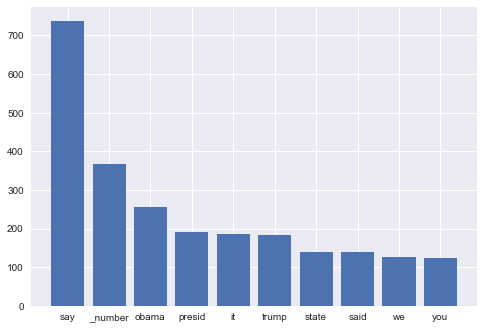

In [54]:
_ = plt.bar(x=S_PantsOnFire_words_count.index[:10], height=S_PantsOnFire_words_count.values[:10])

*FALSE*

In [55]:
# series with lists of words from statements rated as "False"
S_False = DF_Statements.query("assessment == 'false'")['stemmer_statement']

# list of words from all statements rated as "False"
v_false = []  
for v_word in S_False:
    v_false.extend(v_word)

# number of occurrences of words for "False"
word_count = cl.Counter(v_false) # dict -> (word:cardinality)
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_word_count_false = cl.OrderedDict(sorted_word_count)
S_False_words_count = pd.Series(sorted_dict_word_count_false)
S_False_words_percent = S_False_words_count * 100 / len(v_false) # %

S_False_words_count.name = 'false'
S_False_words_count.index.name = 'word'
S_False_words_percent.name = 'false_percent'
S_False_words_percent.index.name = 'word'

*MOSTLY FALSE*

In [56]:
# series with lists of words from statements rated as "False"
S_MostlyFalse = DF_Statements.query("assessment == 'barely-true'")['stemmer_statement']

# list of words from all statements rated as "Mostly False"
v_mostly_false = []  
for v_word in S_MostlyFalse:
    v_mostly_false.extend(v_word)

# number of occurrences of words for "Mostly False"
word_count = cl.Counter(v_mostly_false) # dict -> (word:cardinality)
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_word_count_mostly_false = cl.OrderedDict(sorted_word_count)
S_MostlyFalse_words_count = pd.Series(sorted_dict_word_count_mostly_false)
S_MostlyFalse_words_percent = S_MostlyFalse_words_count * 100 / len(v_mostly_false) # %

S_MostlyFalse_words_count.name = 'mostlyFalse'
S_MostlyFalse_words_count.index.name = 'word'
S_MostlyFalse_words_percent.name = 'mostlyFalse_percent'
S_MostlyFalse_words_percent.index.name = 'word'

*HALF TRUE*

In [57]:
# series with lists of words from statements rated as "Half True"
S_HalfTrue = DF_Statements.query("assessment == 'half-true'")['stemmer_statement']

# list of words from all statements rated as "Half True"
v_half_true = []  
for v_word in S_HalfTrue:
    v_half_true.extend(v_word)

# number of occurrences of words for "Half True"
word_count = cl.Counter(v_half_true) # dict -> (word:cardinality)
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_word_count_half_true = cl.OrderedDict(sorted_word_count)
S_HalfTrue_words_count = pd.Series(sorted_dict_word_count_half_true)
S_HalfTrue_words_percent = S_MostlyFalse_words_count * 100 / len(v_half_true)

S_HalfTrue_words_count.name = 'halfTrue'
S_HalfTrue_words_count.index.name = 'word'
S_HalfTrue_words_percent.name = 'halfTrue_percent'
S_HalfTrue_words_percent.index.name = 'word'

*MOSTLY TRUE*

In [58]:
# series with lists of words from statements rated as "Mostly True"
S_MostlyTrue = DF_Statements.query("assessment == 'mostly-true'")['stemmer_statement']

# list of words from all statements rated as "Mostly True" 
v_mostly_true = [] 
for v_word in S_MostlyTrue:
    v_mostly_true.extend(v_word)

# number of occurrences of words for "Mostly True"
word_count = cl.Counter(v_mostly_true) # dict -> (word:cardinality)
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_word_count_mostly_true = cl.OrderedDict(sorted_word_count)
S_MostlyTrue_words_count = pd.Series(sorted_dict_word_count_mostly_true)
S_MostlyTrue_words_percent = S_MostlyFalse_words_count * 100 / len(v_mostly_true)

S_MostlyTrue_words_count.name = 'mostlyTrue'
S_MostlyTrue_words_count.index.name = 'word'
S_MostlyTrue_words_percent.name = 'mostlyTrue_percent'
S_MostlyTrue_words_percent.index.name = 'word'

*TRUE*

In [59]:
# series with lists of words from statements rated as "True"
S_True = DF_Statements.query("assessment == 'true'")['stemmer_statement']

# list of words from all statements rated as "True" 
v_true = [] 
for v_word in S_True:
    v_true.extend(v_word)

# number of occurrences of words for "True"
word_count = cl.Counter(v_true) # dict -> (word:cardinality)
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict_word_count_true = cl.OrderedDict(sorted_word_count)
S_True_words_count = pd.Series(sorted_dict_word_count_true)
S_True_words_percent = S_True_words_count * 100 / len(v_true) # %

S_True_words_count.name = 'true'
S_True_words_count.index.name = 'word'
S_True_words_percent.name = 'true_percent'
S_True_words_percent.index.name = 'word'

#### Matrix of word counts for statement assessments

the number of occurrences of words for each assessment of statements

In [60]:
DF_WordCountMatrix = pd.concat([S_all_words_count,
                                S_PantsOnFire_words_count,
                                S_False_words_count,
                                S_MostlyFalse_words_count,
                                S_HalfTrue_words_count,
                                S_MostlyTrue_words_count,
                                S_True_words_count,
                               ],axis=1)
pd.options.display.float_format = "{:,.0f}".format # precision - zero decimal digits
DF_WordCountMatrix.head(15)

,allWords,pantsOnFire,false,mostlyFalse,halfTrue,mostlyTrue,true
say,4802,737,"1,168",857,871,685,484
_number,4509,366,753,630,"1,031","1,016",713
state,2135,140,388,315,455,459,378
_dollar,2010,117,361,385,473,436,238
we,1962,127,357,347,434,395,302
_percent,1960,81,260,284,469,511,355
it,1950,186,412,336,407,382,227
year,1888,112,329,298,397,428,324
tax,1636,110,295,321,388,329,193
obama,1325,256,295,247,239,161,127


#### Matrix of word counts for statement assessments in percent

In [61]:
DF_WordPercentMatrix = pd.concat([S_all_words_percent,
                                S_PantsOnFire_words_percent,
                                S_False_words_percent,
                                S_MostlyFalse_words_percent,
                                S_HalfTrue_words_percent,
                                S_MostlyTrue_words_percent,
                                S_True_words_percent,
                                ],axis=1)
pd.options.display.float_format = "{:,.2f}".format # precision - 2 decimal digits
DF_WordPercentMatrix.head(15)

,allWords_percent,pantsOnFire_percent,false_percent,mostlyFalse_percent,halfTrue_percent,mostlyTrue_percent,true_percent
say,2.38,3.27,2.83,2.46,2.14,2.37,1.79
_number,2.23,1.62,1.83,1.81,1.57,1.74,2.63
state,1.06,0.62,0.94,0.91,0.78,0.87,1.39
_dollar,1.00,0.52,0.88,1.11,0.96,1.06,0.88
we,0.97,0.56,0.87,1.00,0.86,0.96,1.11
_percent,0.97,0.36,0.63,0.82,0.71,0.78,1.31
it,0.97,0.82,1.00,0.97,0.84,0.93,0.84
year,0.93,0.50,0.80,0.86,0.74,0.82,1.19
tax,0.81,0.49,0.72,0.92,0.80,0.89,0.71
obama,0.66,1.14,0.72,0.71,0.62,0.68,0.47


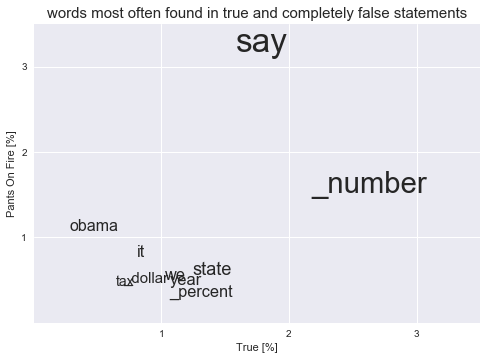

In [62]:
# 10 most common words in statements 

def FUN_text_size(total):
    return 8 + total*5


DF_trueFalese = DF_WordPercentMatrix[["true_percent","pantsOnFire_percent"]]
for i in range(10):
    x = DF_trueFalese.true_percent[i]
    y = DF_trueFalese.pantsOnFire_percent[i]
    s = DF_trueFalese.index[i]
    plt.text(x, y, s, ha='center', va='center', size=FUN_text_size(x+y))
plt.xlabel('True [%]')
plt.ylabel('Pants On Fire [%]')
plt.axis([0,3.5,0,3.5])
plt.xticks([1,2,3])
plt.yticks([1,2,3])
plt.title('words most often found in true and completely false statements', fontdict={'fontsize':15})
plt.style.use('seaborn') 
plt.show()
# y-> true_percent, x -> pantsOnFire_percent

# str.230

### 2.2.6 Processed statements
Irrelevant words to be removed from statements

In [63]:
# content of statements after word processing
stemmer_statements = DF_Statements.stemmer_statement.values.tolist() 
processedStatements = [" ".join(d) for d in stemmer_statements] # list of processed statements
processedStatements[:5]

['usa nih in_year give _dollar wuhan lab china grant prohibit in_year pre obama grant except',
 'homeless peopl immun covid19',
 'say presid donald trump sell coronavirusthem commemor coin white hous gift shop',
 'walmart amazon kroger target costco report coronaviru case news',
 'say wisconsin measur prevent death least _number wisconsinit perhap mani _number live']

In [64]:
# statements after processing
DF_Statements.insert(loc=8, column='processed_statement',value=processedStatements)
DF_Statements.head()

,speaker,targets,statement,assessment,cleaned_statement,tokenized_statement,stopwords_statement,stemmer_statement,processed_statement,publication_date
id,,,,,,,,,,
18460,Rudy Giuliani,[],"""Why did the US (NIH) in 2017 give $3.7m to the Wuhan Lab in China? Such grants were prohibited ...",false,why did the usa nih in_YEAR give _DOLLARS to the wuhan lab in china such grants were prohibited ...,"[why, did, the, usa, nih, in_YEAR, give, _DOLLARS, to, the, wuhan, lab, in, china, such, grants,...","[usa, nih, in_YEAR, give, _DOLLARS, wuhan, lab, china, grants, prohibited, in_YEAR, pres, obama,...","[usa, nih, in_year, give, _dollar, wuhan, lab, china, grant, prohibit, in_year, pre, obama, gran...",usa nih in_year give _dollar wuhan lab china grant prohibit in_year pre obama grant except,2020-05-01T17:34:36-04:00
18456,Facebook posts,[],Homeless people are immune to COVID-19,pants-fire,homeless people are immune to covid-19,"[homeless, people, are, immune, to, covid-19]","[homeless, people, immune, covid19]","[homeless, peopl, immun, covid19]",homeless peopl immun covid19,2020-05-01T17:19:18-04:00
18459,Facebook posts,[],Says President Donald Trump is selling coronavirus-themed commemorative coins through the White ...,false,says president donald trump is selling coronavirus-themed commemorative coins through the white ...,"[says, president, donald, trump, is, selling, coronavirus-themed, commemorative, coins, through,...","[says, president, donald, trump, selling, coronavirusthemed, commemorative, coins, white, house,...","[say, presid, donald, trump, sell, coronavirusthem, commemor, coin, white, hous, gift, shop]",say presid donald trump sell coronavirusthem commemor coin white hous gift shop,2020-05-01T17:18:14-04:00
18458,Viral image,[],"Walmart, Amazon, Kroger, Target and Costco “have not had any reported (coronavirus) cases in the...",false,walmart amazon kroger target and costco have not had any reported coronavirus cases in the news,"[walmart, amazon, kroger, target, and, costco, have, not, had, any, reported, coronavirus, cases...","[walmart, amazon, kroger, target, costco, reported, coronavirus, cases, news]","[walmart, amazon, kroger, target, costco, report, coronaviru, case, news]",walmart amazon kroger target costco report coronaviru case news,2020-05-01T16:05:36-04:00
18457,Tony Evers,[],"Says Wisconsin measures have ""prevented the death of at least 300 Wisconsinites, and perhaps as ...",mostly-true,says wisconsin measures have prevented the death of at least _NUMBER wisconsinites and perhaps a...,"[says, wisconsin, measures, have, prevented, the, death, of, at, least, _NUMBER, wisconsinites, ...","[says, wisconsin, measures, prevented, death, least, _NUMBER, wisconsinites, perhaps, many, _NUM...","[say, wisconsin, measur, prevent, death, least, _number, wisconsinit, perhap, mani, _number, live]",say wisconsin measur prevent death least _number wisconsinit perhap mani _number live,2020-05-01T12:54:52-04:00


## 2.3 Data and Labels

In [65]:
DF_Statements.processed_statement.head(3)

id
18460    usa nih in_year give _dollar wuhan lab china grant prohibit in_year pre obama grant except
18456                                                                  homeless peopl immun covid19
18459               say presid donald trump sell coronavirusthem commemor coin white hous gift shop
Name: processed_statement, dtype: object

In [66]:
processedStatements[:3]

['usa nih in_year give _dollar wuhan lab china grant prohibit in_year pre obama grant except',
 'homeless peopl immun covid19',
 'say presid donald trump sell coronavirusthem commemor coin white hous gift shop']

### 2.3.1 Data

In [67]:
X = DF_Statements.processed_statement
X[:3]

id
18460    usa nih in_year give _dollar wuhan lab china grant prohibit in_year pre obama grant except
18456                                                                  homeless peopl immun covid19
18459               say presid donald trump sell coronavirusthem commemor coin white hous gift shop
Name: processed_statement, dtype: object

### 2.3.2 Labels

In [68]:
# labels - division into 2 classes: 1 positive (wanted), 0 negative
y = (DF_Statements['assessment'])
y

id
18460          false
18456     pants-fire
18459          false
18458          false
18457    mostly-true
            ...     
8              false
11              true
3        mostly-true
30              true
31              true
Name: assessment, Length: 17355, dtype: object

### 2.3.3 Train/test split
division of data into training set and test data

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25) # test set -> 25%

print('Number of items')
print('X_train:', len(X_train))
print('X_test:', len(X_test))
print('y_train:', len(y_train))
print('y_test:', len(y_test))

Number of occurrences
X_train: 13016
X_test: 4339
y_train: 13016
y_test: 4339


In [70]:
X_train[:3]

id
13030        cast decid vote extend medicaid health care coverag _number our fellow citizen
11991                   sinc welfar reform sign law number famili live extrem poverti doubl
7068     gubernatori candid maggi hassan support _number tax fee increas senat major leader
Name: processed_statement, dtype: object

In [71]:
X_train.values[:3]

array(['cast decid vote extend medicaid health care coverag _number our fellow citizen', 'sinc welfar reform sign law number famili live extrem poverti doubl', 'gubernatori candid maggi hassan support _number tax fee increas senat major leader'], dtype=object)

In [72]:
y_train.values[:3]

array(['barely-true', 'mostly-true', 'half-true'], dtype=object)

In [73]:
X_test.values[:3]

array(['say _number texa univers announc implement _dollar degre', 'aclu file suit militari crossshap headston remov', 'gener assembl explicit constitut author impos incom sale estat myriad tax upon us'], dtype=object)

In [74]:
y_test.values[:3]

array(['barely-true', 'pants-fire', 'true'], dtype=object)

## 2.4 Saving data to files

In [75]:
DF_Statements.drop(columns=['tokenized_statement','stopwords_statement'], inplace=True)

In [76]:
DF_Statements.head(3)

,speaker,targets,statement,assessment,cleaned_statement,stemmer_statement,processed_statement,publication_date
id,,,,,,,,
18460,Rudy Giuliani,[],"""Why did the US (NIH) in 2017 give $3.7m to the Wuhan Lab in China? Such grants were prohibited ...",false,why did the usa nih in_YEAR give _DOLLARS to the wuhan lab in china such grants were prohibited ...,"[usa, nih, in_year, give, _dollar, wuhan, lab, china, grant, prohibit, in_year, pre, obama, gran...",usa nih in_year give _dollar wuhan lab china grant prohibit in_year pre obama grant except,2020-05-01T17:34:36-04:00
18456,Facebook posts,[],Homeless people are immune to COVID-19,pants-fire,homeless people are immune to covid-19,"[homeless, peopl, immun, covid19]",homeless peopl immun covid19,2020-05-01T17:19:18-04:00
18459,Facebook posts,[],Says President Donald Trump is selling coronavirus-themed commemorative coins through the White ...,false,says president donald trump is selling coronavirus-themed commemorative coins through the white ...,"[say, presid, donald, trump, sell, coronavirusthem, commemor, coin, white, hous, gift, shop]",say presid donald trump sell coronavirusthem commemor coin white hous gift shop,2020-05-01T17:18:14-04:00


In [77]:
DF_Statements.shape

(17355, 8)

In [78]:
DF_Statements.to_json("./Data/Statements_processed.json") # write data frame with processed statements to JSON
DF_Statements.to_csv("./Data/Statements_processed.csv") # write data frame with processed statements to CSV

# write to CSV

X.to_csv('./Data/X.csv') 
y.to_csv('./Data/y.csv')

X_train.to_csv('./Data/X_train.csv')
y_train.to_csv('./Data/y_train.csv')
X_test.to_csv('./Data/X_test.csv')
y_test.to_csv('./Data/y_test.csv')